# Computing Lyapunov exponents of Lorenz system
This script computes the Lyapunov exponents of the Lorenz system from one dimensional time series data sampled from the system. First, the optimal embedding parameters are choosen. Then the data is embedded using time delay and PCA. On this embedded data the Lyapunov spectrum is estimated using an iterative algorithm as well as linear regression to approximate the value of the Jacobian.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import math as math

from tqdm import tqdm
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks

## Simulating the system

In [3]:
#parameters of the system
rho = 45.92
sigma = 16
beta = 4

#Initial condition
state0 = np.array([-8, -8, 27])

def difeq(data,t):
    '''System of differential eqautions'''
    x,y,z=data
    xp=sigma*(y-x)
    yp=x*(rho-z)-y
    zp=x*y-beta*z
    return [xp,yp,zp]

dt=0.01
T=10000
discard_t = 100
T_total = T+discard_t
t=np.arange(0,T_total,dt)
data=integrate.odeint(difeq,state0,t)[int(discard_t/dt):]
N=len(data)
#Data along X
Xdata=data[:,0]

## Embed time series data 
In this section the data is embedded using the time delay matrix followed by dimensionality reduction using ICA. In order to find the optimal parameters of the embedding, the prediction time is maximized.

### Embedding functions

In [6]:
def getLag(tseries,m,tau=1):
    '''Input: Lag step tau ( = distance between lags),
    m = dimension of lag vector, tseries = time series data'''
    lengthY=tseries.shape[0]
    Ncolumns=m
    Nrows=math.ceil(lengthY/tau)-Ncolumns+1
    x=np.zeros([Nrows,Ncolumns])
    for k in range(Nrows):
        #Constructing the lag vector 
        xk=tseries[tau*k::tau]
        
        #Broadcasting them into same shape
        xk=np.array(xk[0:Ncolumns])
        x[k,:]=xk
    return x

def whitening(X):
    '''Does the ICA'''
    #Subtracting the mean of each column
    Xmean=np.mean(X,axis=0)
    X_centered = X-Xmean
    
    Sigma=np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    modes, Lambda, V = np.linalg.svd(Sigma)
    W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), modes.T) #we add a regularizing term
    return modes,Xmean,W,np.dot(X_centered, W.T)

def invert_transform(phspace,w,xmean):
    '''Inverts the ICA'''
    if len(phspace.shape)>1:
        m = phspace.shape[1]
    else: 
        m = phspace.shape[0]
    return phspace.dot(np.linalg.pinv(w[:m,:].T))+xmean

In [7]:
def linear_fit(x,y):
    reg = LinearRegression().fit(x.reshape(-1,1), y)
    r2 = reg.score(x.reshape(-1,1),y)
    m = reg.coef_
    b = reg.intercept_
    return r2,m,b

def prediction_time(mean_distance,n_iters=20):
    tau0 = np.random.randint(int(len(mean_distance)*.05),int(.95*len(mean_distance)))
    es0=mean_distance[tau0]
    intE = np.cumsum(mean_distance)
    len_dist = len(mean_distance)
    x,y = np.arange(tau0,len(mean_distance)),intE[tau0:len(mean_distance)]
    r2,new_es,A = linear_fit(x,y)
    new_tau= np.arange(len(mean_distance))[mean_distance>new_es][0]
    Tpreds = [-A/new_es,]
    r2s=[r2,]
    es = [new_es,]
    for k in range(n_iters):
        x,y = np.arange(new_tau,len(mean_distance)),intE[new_tau:len(mean_distance)]
        r2,new_es,A = linear_fit(x,y)
        new_tau= np.arange(len(mean_distance))[mean_distance>new_es][0]
        Tpreds.append(-A/new_es)
        r2s.append(r2)
        if np.abs(new_es-es[-1])<1e-8:
            break
        es.append(new_es)
    return r2s,np.hstack(Tpreds)


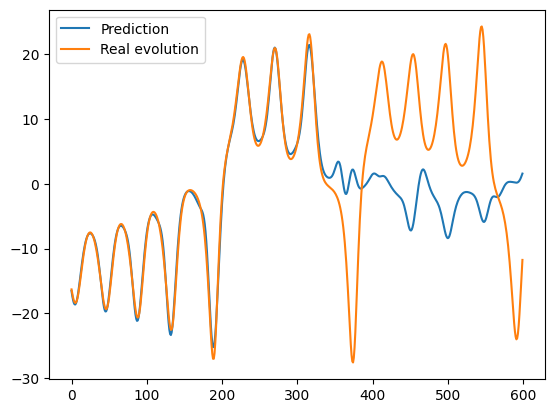

In [8]:
predictedevolution=[]
#Point at which we predict
p0=300

#Dimension of the timeseries
dimtimeseries=1

#Value of K
K=18
m=3


#Number of nearest neighbours included in computations
Np=20

u,xmean,w,XPCA=whitening(getLag(Xdata,K))
XPCA=XPCA[:,:m]
Steps=len(XPCA)

taumax=600
#Computing distance in reconstructed phase space and keeping Nearest neigbhours
disttoxt=np.sqrt(np.sum(np.square((XPCA[:-taumax]-XPCA[p0])),axis=1))

#Excluding nearest neighbours in time
disttoxt[p0-20:p0+20]=np.Inf

#Keeping only clostest points
sort_index = np.argsort(disttoxt)   

for tau in np.arange(0,taumax):
    #Make sure evolved points are in time series
    indevolved=sort_index+tau
    sel=indevolved<Steps
    indevolved=indevolved[sel]
    #Keeping Np closest neigbours
    indevolved=indevolved[0:Np]
    NearNeighbourst=XPCA[indevolved-tau]

    #Evolved nearest neighbours
    NearNeighbourstnew=XPCA[indevolved]
    
    
    #Average over the evolved Nearest neighbours
    xtnew=np.mean(NearNeighbourstnew,axis=0)

    #Go back to real space
    Realspace=invert_transform(xtnew,w,xmean)
    Realspace=Realspace[0:dimtimeseries]
    predictedevolution.append(Realspace)  

direction=0
fig=plt.figure()
plt.plot(np.arange(0,tau+1),np.array(predictedevolution)[:,0],label='Prediction')
plt.plot(np.arange(0,tau+1),data[p0:p0+tau+1,0],label='Real evolution')
plt.legend()
plt.show()


### Maximize predictability to find optimal value of K, m
Predictions are made in the following way: In the delay embedding space, close neighbours in space (not successive points in time) are identified. The Np closest neighbours of a point at time t0 of the time series are taken and their value at a later time t0+tau is evaluated. Going back to observation space allows to evaluate the quality of the prediction.

#### Finding optimal value of number nearest neighbours

In [20]:
#Dimension of the timeseries
dimtimeseries=1
K=17

Lagmat=getLag(Xdata,K)


#Average over t'
points=np.random.choice(np.arange(int(len(Xdata)-1)),size=1500, replace=False)

Npmax=16
#Storing the Nearest neighbour positions
NNIndices=np.zeros((len(points),Npmax),dtype=int)
for kp,p0 in enumerate(points):
    if kp % 100==0: print(kp)
    disttoxt=np.sqrt(np.sum(np.square((Lagmat[:-1]-Lagmat[p0])),axis=1))
    #Excluding nearest neighbours in time
    disttoxt[p0-20:p0+20]=np.Inf
    #Keeping only clostest points
    sort_index = np.argsort(disttoxt)   
    NNIndices[kp] = sort_index[:Npmax]

#Compute one step prediction error in reconstructed space
eps_Np = np.zeros((Npmax-1,len(points)))
Np_range = np.arange(1,Npmax)

for kn,Np in enumerate(Np_range):
    for kp,p0 in enumerate(points):
        pred = np.mean(Lagmat[NNIndices[kp][:Np]+1],axis=0)
        eps_Np[kn,kp] = np.linalg.norm(pred-Lagmat[p0+1])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


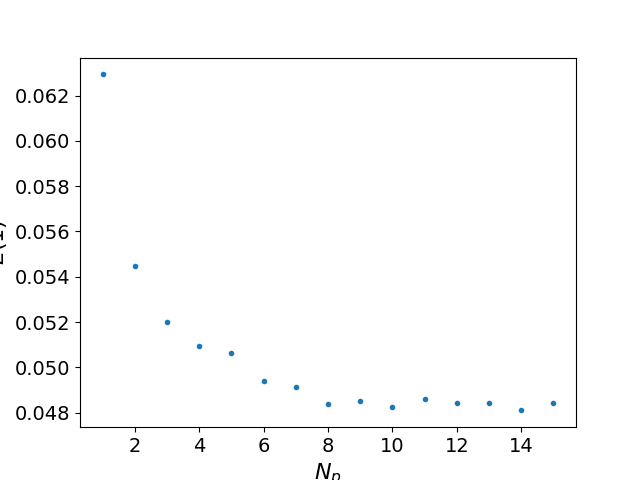

In [21]:
fig, ax = plt.subplots()
plt.plot(Np_range,eps_Np.mean(axis=1),'.');
plt.ylabel(r'$E(1)$',fontsize=16)
plt.xlabel(r'$N_p$',fontsize=16)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

#### Finding optimal value of K (dimension of time delay matrix)


In [22]:
#Dimension of the timeseries
dimtimeseries=1

#K values
Krange=np.arange(2,30)

#Number of nearest neighbours
Np=8

pointsaverage=1000

#Prediction time
Tpred=np.zeros((len(Krange),3))

#Average over tau
taumax=600
taurange=np.arange(0,taumax)

#Average over t'
points=np.random.choice(np.arange(int(len(Xdata)-taumax)),size=pointsaverage, replace=False)


for k,K in enumerate(tqdm(Krange)):
    Lagmat=getLag(Xdata,K)
    #Indices of Nb nearest neighbours for each point in points
    NNIndices=np.zeros((len(points),Np),dtype=int)

    for kp,p0 in enumerate(points):
        disttoxt=np.sqrt(np.sum(np.square((Lagmat[:-taumax]-Lagmat[p0])),axis=1))
        #Excluding nearest neighbours in time
        disttoxt[p0-20:p0+20]=np.Inf

        #Keeping only Np nearest neighbours for each point
        sort_index = np.argsort(disttoxt)  
        NNIndices[kp]=sort_index[:Np]

    #Computing the error for different values of tau and for each point
    eps_p = np.zeros((len(points),taumax))
    for kp in range(len(points)):
        #Evolved nearest neighbours
        NearNeighbourstnew=[Lagmat[NNIndices[kp,kn]:NNIndices[kp,kn]+taumax] for kn in range(Np)]
        Xpred = np.mean(NearNeighbourstnew,axis=0)
        eps_p[kp] = np.sqrt((Xpred[:,-1]-Lagmat[points[kp]:points[kp]+taumax,-1])**2)

    Etau = np.mean(eps_p,axis=0)
    A,B=prediction_time(Etau,n_iters=20)
    mean = B[-1]*dt
    
    #Bootstrapping for errorbars
    n_boot = 1000
    Tpred_boot = np.zeros(n_boot)
    for kb in range(n_boot):
        Etau = eps_p[np.random.randint(0,len(eps_p),len(eps_p))].mean(axis=0)
        A,B=prediction_time(Etau,n_iters=20)
        Tpred_boot[kb] = B[-1]*dt
    cil = np.percentile(Tpred_boot,5)
    ciu = np.percentile(Tpred_boot,95)
    Tpred[k] = [mean,cil,ciu]

100%|████████████████████████████████████████| 28/28 [1:49:32<00:00, 234.73s/it]


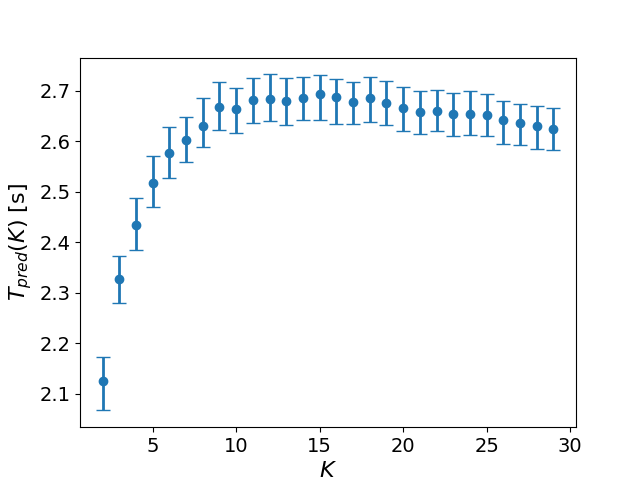

In [24]:
fig, ax = plt.subplots()
plt.errorbar(Krange,Tpred[:,0],yerr = [Tpred[:,0]-Tpred[:,1],Tpred[:,2]-Tpred[:,0]],linewidth=2,capsize=5,fmt='o')
plt.xlabel(r'$K$',fontsize=16)
plt.ylabel(r'$T_{pred}(K)$ [s]',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('K_Lorenz.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

In [25]:
max=Tpred[:,0].max()
posmax=list(Tpred[:,0]).index(max)
K=Krange[posmax]
print(K)

15


#### Finding optimal value of m 

In [26]:
K=15
#Dimension of the timeseries
dimtimeseries=1
pointsaverage=1000

#Average over tau
taumax=600

#Average over t'
points=np.random.choice(np.arange(int(len(Xdata)-taumax)),size=pointsaverage, replace=False)

Lagmat=getLag(Xdata,K)
modes,xmean,w,XICA_all=whitening(Lagmat)


#Tpred for different values of m
mrange = np.arange(1,7)
Tpred=np.zeros((len(mrange),3))


for km,m in enumerate(tqdm(mrange)):    
    #Picking m first IC's
    XPCA= XICA_all[:,:m]
    #Getting nearest nearest neighbours
    NNIndices=np.zeros((len(points),Np),dtype=int)
    for kp,p0 in enumerate(points):
        disttoxt=np.sqrt(np.sum(np.square((XPCA[:-taumax]-XPCA[p0])),axis=1))
        #Excluding nearest neighbours in time
        disttoxt[p0-20:p0+20]=np.Inf
        #Keeping only clostest points
        sort_index = np.argsort(disttoxt)   
        NNIndices[kp] = sort_index[:Np]
    
    eps_p = np.zeros((len(points),taumax))  
    
    for kp in range(len(points)):
        #Predicting evolution in reconstructed space
        NearNeighbourstnew=[XPCA[NNIndices[kp,kn]:NNIndices[kp,kn]+taumax] for kn in range(Np)]
        XPCA_pred = np.mean(NearNeighbourstnew,axis=0)
        #Going back to realspace
        Xpred = invert_transform(XPCA_pred,w,xmean)
        #Computing the prediction error
        eps_p[kp] = np.sqrt((Xpred[:,-1]-Lagmat[points[kp]:points[kp]+taumax,-1])**2)
    
    Etau = np.mean(eps_p,axis=0)
    A,B=prediction_time(Etau,n_iters=20)
    mean = B[-1]*dt        
    
    #Bootstrapping for errorbars
    n_boot = 1000
    Tpred_boot = np.zeros(n_boot)
    for kb in range(n_boot):
        Etau = eps_p[np.random.randint(0,len(eps_p),len(eps_p))].mean(axis=0)
        A,B=prediction_time(Etau,n_iters=20)
        Tpred_boot[kb] = B[-1]*dt
    cil = np.percentile(Tpred_boot,5)
    ciu = np.percentile(Tpred_boot,95)
    Tpred[km] = [mean,cil,ciu]


100%|█████████████████████████████████████████████| 6/6 [09:48<00:00, 98.16s/it]


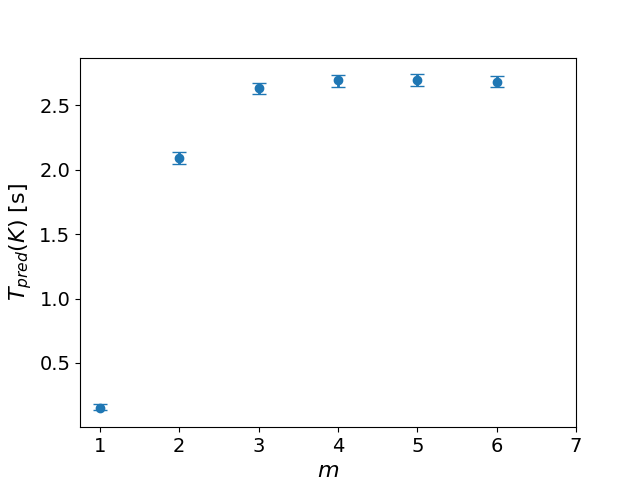

In [27]:
fig, ax = plt.subplots()
plt.errorbar(mrange,Tpred[:,0],yerr = [Tpred[:,0]-Tpred[:,1],Tpred[:,2]-Tpred[:,0]] ,linewidth=2,capsize=5,fmt='o')
plt.xlabel(r'$m$',fontsize=16)
plt.ylabel(r'$T_{pred}(K)$ [s]',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7], labels=['1','2','3','4','5','6','7'])
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('m_Lorenz.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

#### Embedding the time series using the above found values of (K,m)

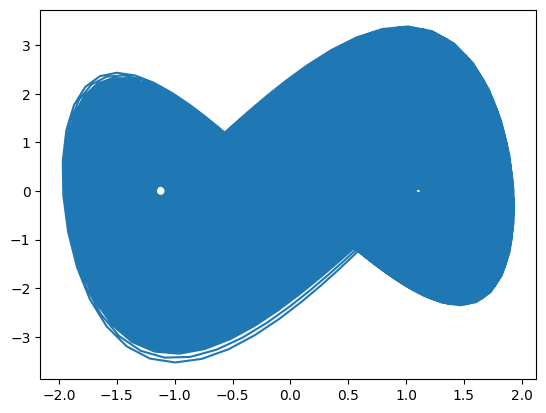

In [9]:
mmin=3
K=15
Lagmat=getLag(Xdata,K)
modes,xmean,w,XICA_all=whitening(Lagmat)
X=XICA_all[:,:mmin]
plt.figure()
plt.plot(X[:,0],X[:,1])

### Determining the average distance after one orbit
Using the methods explained in "Capturing the continuous complexity of behaviour in Caenorhabditis elegans", one finds the average distance of phase space points after a given number of recurrences.

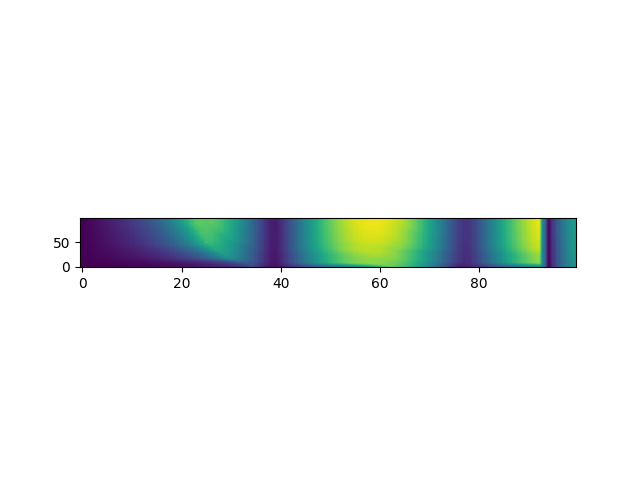

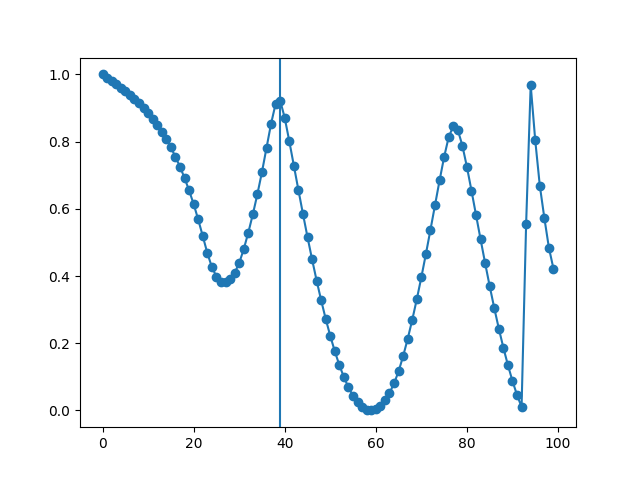

0.009709948230314153


In [36]:
#Maximal orbit length
tmax=100
#Number of considered recurrences
rmax=100
#Point where we compute the average distance
t0 = 200

eps_r_t = np.zeros((rmax,tmax))

for i in range(1,tmax):
    tp = np.linalg.norm(X[t0:-i]-X[t0+i:],axis=1)
    tp = np.sort(tp)
    eps_r_t[:,i] = tp[:rmax]

plt.figure()
plt.imshow(eps_r_t,aspect=1e-1,origin='lower')
plt.show()

def norm2one(x):
    ma=np.max(x,axis=0);
    mi=np.min(x,axis=0);
    return (x-mi)/(ma-mi)

#Distance averaged over recurrences
eps_t = np.mean(eps_r_t,axis=0)

#Finding minimal distances --> Periodic orbits
peaks, _ = find_peaks(norm2one(-eps_t), prominence=.01)
plt.figure()
plt.plot(np.arange(tmax),norm2one(-eps_t),marker='o')
plt.axvline(peaks[0])
plt.show()

epsilon = eps_t[peaks[0]]
print(epsilon)

## Computing the Lyapunov exponents

In [10]:
def QR_decomp(Matrix):
    '''This fct does QR decomposition of the input matrix 
    and makes sure that the diagonal element of R are positive
    (This is conventional as the QR decomposition is not unique)'''
    Qmat,Rmat = np.linalg.qr(Matrix)
    Rdiag=np.diag(Rmat)
    for k in range(len(Rdiag)):
        if Rdiag[k]<0:
            Rmat[k,:]=-Rmat[k,:]
            Qmat[:,k]=-Qmat[:,k]
    return Qmat,Rmat

def estimate_lyap_exp(Ms,L=1,N=1000):
    '''This fct iteratively computes the Lyapunov exponents
    for N iterations for a given set of flow matrices M=exp(J*dt)'''
    #Dimension of state space
    dim = Ms[0].shape[1]
    #Global flow
    Flow = np.identity(dim)
    Qhat = np.identity(dim)
    #local exp(Jacobian*dt) at point data[0]
    M=Ms[0]
    #Using Q,R decomposition
    Q, R = QR_decomp(M)
    #Storing the Lyapunov exponents
    exponents = np.zeros(len(R))
    exps = []
    for i in range(1,N):
        M = Ms[i]
        Flow = np.dot(M,Flow)
        #Compute Lyapunov exponent
        if i % L == 0:
            Flow = np.linalg.multi_dot([Qhat.T, Flow, Qhat])
            Q, R = QR_decomp(Flow)
            exponents=exponents+np.log(np.diag(R))
            #Compute new Qhat
            Qhat = np.dot(Qhat,Q)
            #Reset the flow
            Flow = np.identity(dim)
            exps.append(exponents/(i*dt))
    return exps

def estimate_discrete_jac(X,epsilon,trange,small_weight_threshold=1e-3,T1=1):
    '''This fct estimates the flow matrices at points in X. Epsilon is the
    average distance after a recurrence, small_weight_treshold is a parameter
    for speeding up the computations by excluding small weights in the linear
    regression.'''
    Ms=np.zeros((len(trange),X.shape[1],X.shape[1]))
    #Initial state
    XX=X[:-T1,:]
    #Evolved state
    Xn=X[T1:,:]
    #Computing all the exp(J*dt) matrices
    for ipred in trange:
        sel = np.ones(len(XX),dtype=bool)
        #Exclude the point where we estimate
        sel[ipred] = False
        dist = np.linalg.norm(XX-XX[ipred],axis=1)
        wts = np.exp(-dist/epsilon)
        #Excluding the nearest neighbours from the same recurrence
        if ipred<10:
            wts[:ipred]=0
        elif len(wts)-ipred<10:
            wts[-ipred:]=0
        else:
            wts[ipred-10:ipred+10]=0
            
        #Excluding points with small weight
        sel[wts/wts.max()<small_weight_threshold] = False
        if sel.sum()<4:
            print("Very few points (",(sel.sum()),")", " at step : ",ipred, " decrease small_weight_treshold?")
            
        wts = wts[sel]
        #Stacking column of ones to have additional parameter in regression
        z=np.hstack([np.ones(sel.sum()).reshape(-1,1),XX[sel]])
        zw = np.vstack([z[:,m]*wts for m in range(z.shape[1])]).T
        znw =  np.vstack([Xn[sel,m]*wts for m in range(Xn.shape[1])]).T
        #Doint the linear regression
        A = np.linalg.pinv(zw).dot(znw)
        #Getting rid of constants
        Ms[ipred] = A[1:].T
    return Ms

### Optimizing epsilon
As we know that one of the exponents should be zero, we can try to vary epsilon in order to find an exponent as close to zero as possible.

[  1.64464143   0.01888288 -16.04415576]
[  1.64565633   0.01716797 -16.04444262]
[ 1.64930013e+00  1.26163393e-02 -1.59568629e+01]
[ 1.64860315e+00  1.25718440e-02 -1.59208097e+01]
[ 1.65096498e+00  9.03812322e-03 -1.59702249e+01]
[ 1.65055635e+00  8.08151799e-03 -1.58368544e+01]
[ 1.65433987e+00  6.02805237e-03 -1.58540882e+01]
[ 1.65464964e+00  4.34597540e-03 -1.55939199e+01]
[ 1.65369749e+00  3.49659729e-03 -1.53659448e+01]
[ 1.65260582e+00  2.67952186e-03 -1.52886730e+01]
[ 1.65215850e+00  1.21756973e-03 -1.51547409e+01]
[ 1.65180046e+00 -1.94080419e-04 -1.51226999e+01]
[ 1.65156447e+00 -1.55793805e-03 -1.51873660e+01]
[ 1.65206376e+00 -3.70128716e-03 -1.50139159e+01]
[ 1.65280274e+00 -6.08416390e-03 -1.48079754e+01]
0.007872778817029788


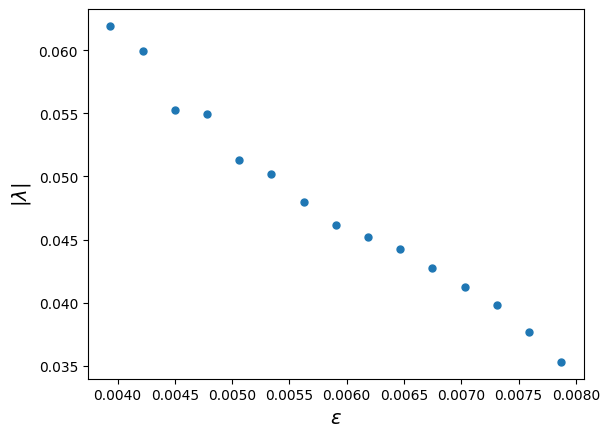

In [114]:
trange = np.arange(0,1000)
#Perturbation of epsilon
epsvalues=np.linspace(0.4*epsilon,0.8*epsilon,15)
zeroexp=[]
for eps in epsvalues:
    Ms = estimate_discrete_jac(X,eps,trange)
    exps = estimate_lyap_exp(Ms,N=len(Ms))
    print(np.mean(exps[-100:],axis=0))
    zeroexp.append(abs(np.mean(exps[-40:],axis=0)).min())
mi=min(zeroexp)
pos=zeroexp.index(mi)
print(epsvalues[pos])

fig=plt.figure()
plt.plot(epsvalues,zeroexp,'.',markersize=10)
plt.xlabel("$\epsilon$",fontsize=14)
plt.ylabel("$|\lambda|$",fontsize=14)
#fig.savefig('EpsilonOptim_Lorenz.png', format='png', dpi=1200)
plt.show()

### Computing exponents

In [11]:
epsilonvar=0.007872778817029788
trange = np.arange(0,5000)
#Getting the exp(J*dt) matrices
Ms = estimate_discrete_jac(X,epsilonvar,trange)

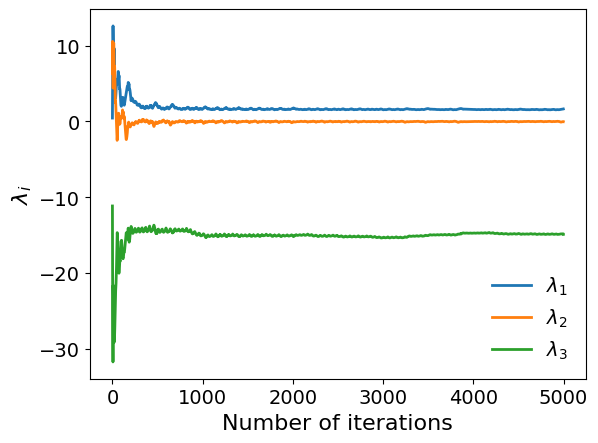

Average over last 1000 values :  [ 1.57548141e+00 -7.74275952e-03 -1.48217232e+01]
Error [0.02135742 0.01895463 0.06489678]


In [12]:
#Computing the Lyapunov exponents
exps = np.array(estimate_lyap_exp(Ms,N=len(Ms)))

fig, ax = plt.subplots()
plt.plot(exps,linewidth=2,label=["$\lambda_1$","$\lambda_2$","$\lambda_3$"])
plt.legend(frameon=False,fontsize=14)
plt.xlabel("Number of iterations",fontsize=16)
plt.ylabel("$\lambda_i$",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('LyapConv_Lorenz.png', format='png',dpi=600,bbox_inches='tight')
plt.show()

print("Average over last 1000 values : ",np.mean(exps[-1000:],axis=0))
print("Error",exps[-1000:].std(axis=0))

## Computing Fractal dimension

In [34]:
Exponents=np.mean(exps[-1000:],axis=0)
#Kaplan-York dimension (https://mathworld.wolfram.com/Kaplan-YorkeDimension.html)
D=2+(Exponents[0]+Exponents[1])/np.abs(Exponents[2])
print("Kaplan-Yorke Dimension : ",D)
expsall=exps[-1000:]
dimerror=((expsall[:,0]+expsall[:,1])/np.abs(exps[-1000:,2])).std(axis=0)
print("Kaplan-Yorke dimension error: ",dimerror)

Kaplan-Yorke Dimension :  2.105773035230748
Kaplan-Yorke dimension error:  0.0013996878469989013
